In [205]:
import os
%matplotlib inline
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
import imageio
import cv2
import time

import datetime as dt
import pandas as pd
import random
import radon_monitor
rm = radon_monitor.Radon_Monitor()

1683 previous radon measurements found


In [206]:
from custom_image_tools import browse_files, cutout, send_back_to_training


# Purpose
1) develop a program to read raw images and outputs DataFrame of historical data and visualizations

## Table of Contents <a name = 'toc'></a>
1. Pull Historical Data
2. Add New Raw Images
3. Random Sampling/Browsing
4. Reading Images
5. View Model Disagreement
6. Visualizations
7. Save Data

## Pull Historical Data

In [207]:
data_fp = '/Volumes/sambashare/projects/radon_monitor/data/'
hourly_test_fp = data_fp + 'hourly_tests/'
og_images_fp = data_fp + 'og_images/'

In [208]:
img_df = pd.read_csv('./results.csv')
img_df['img_date'] = pd.to_datetime(img_df['img_date'])
img_df = img_df.dropna(subset = ['short_term_span'])
img_df['month'] = img_df['img_date'].dt.month
img_df['day'] = img_df['img_date'].dt.day
img_df['year'] = img_df['img_date'].dt.year
print(len(img_df))
img_df.head()


1683


,img_date,img_path,img_name,short_term_span,short_term,long_term,nn_short_term_span,nn_short_term,nn_long_term,models agree,hour,month,day,year
0,2021-11-04 08:01:00,/Volumes/sambashare/projects/radon_monitor/dat...,test_11-04-2021_0801.png,1.0,2.91,3.67,1.0,2.91,3.67,True,8.0,11,4,2021
1,2021-11-04 09:02:00,/Volumes/sambashare/projects/radon_monitor/dat...,test_11-04-2021_0902.png,7.0,4.10,3.67,7.0,4.10,3.67,True,9.0,11,4,2021
2,2021-11-04 10:03:00,/Volumes/sambashare/projects/radon_monitor/dat...,test_11-04-2021_1003.png,1.0,2.94,3.67,1.0,2.94,3.67,True,10.0,11,4,2021
3,2021-11-04 11:04:00,/Volumes/sambashare/projects/radon_monitor/dat...,test_11-04-2021_1104.png,1.0,3.00,3.67,1.0,3.00,3.67,True,11.0,11,4,2021
4,2021-11-04 12:05:00,/Volumes/sambashare/projects/radon_monitor/dat...,test_11-04-2021_1205.png,7.0,4.10,3.67,7.0,4.10,3.67,True,12.0,11,4,2021


## Add New Raw Images

In [95]:
# Intalize a fresh data set
#img_df = pd.DataFrame(columns = ['img_date','img_path','img_name'])

In [209]:
# intilize dataframe for images not analyzied yet
new_img = pd.DataFrame()
for i, f in enumerate(os.scandir(hourly_test_fp)):
    if not f.name.startswith('test'):continue
    if not f.name in list(img_df['img_name']):
    
        new_img.loc[i,'img_date'] = rm._date_extractor(f.name)
        new_img.loc[i,'img_path'] = hourly_test_fp+f.name 
        new_img.loc[i,'img_name'] = f.name

new_img = new_img.sort_values(by='img_date',ascending = False)\
             .reset_index(drop = True)
print(new_img.shape)
new_img.head()

(35, 3)


,img_date,img_path,img_name
0,2022-02-20 09:25:00,/Volumes/sambashare/projects/radon_monitor/dat...,tests_02-20-2022_0925.png
1,2022-02-20 08:24:00,/Volumes/sambashare/projects/radon_monitor/dat...,tests_02-20-2022_0824.png
2,2022-02-20 07:23:00,/Volumes/sambashare/projects/radon_monitor/dat...,tests_02-20-2022_0723.png
3,2022-02-20 06:22:00,/Volumes/sambashare/projects/radon_monitor/dat...,tests_02-20-2022_0622.png
4,2022-02-20 05:21:00,/Volumes/sambashare/projects/radon_monitor/dat...,tests_02-20-2022_0521.png


In [6]:
def get_coordinates(fp,position):
    position_coord_df = rm.coordinates(fp)
    position_mask = position_coord_df['position'] == position
    return position_coord_df[position_mask].coordinates.values[0]
    
#get_coordinates(img_df.loc[0,'img_path'],'short_term_0')

In [7]:
def read_image(image_fp_,model,returns_array = True,display_img = False,normalize = False):
    if display_img: browse_files(image_fp_)
    def read_cutout(cut):
        the_image = cutout(cut,image_fp_,return_data=True,show = False)
        the_image = cv2.resize(the_image,(28,28)).flatten()
        if normalize:
            the_image = the_image
        pred = model.predict(the_image.reshape((1,-1))/255)[0]
        if returns_array:return pred.argmax()
        else: return pred

    short_term_days_value = read_cutout(get_coordinates(image_fp_,'short_term_span'))
    
    short_term_0_value = read_cutout(get_coordinates(image_fp_,'short_term_0'))
    short_term_1_value = read_cutout(get_coordinates(image_fp_,'short_term_1'))
    short_term_2_value = read_cutout(get_coordinates(image_fp_,'short_term_2'))
    short_term_value = short_term_0_value + 0.1* short_term_1_value + 0.01 * short_term_2_value
    
    long_term_0_value = read_cutout(get_coordinates(image_fp_,'long_term_0'))
    long_term_1_value = read_cutout(get_coordinates(image_fp_,'long_term_1'))
    long_term_2_value = read_cutout(get_coordinates(image_fp_,'long_term_2'))
    long_term_value = long_term_0_value + 0.1 * long_term_1_value + 0.01*long_term_2_value
    
    values = {'days':int(short_term_days_value),
             'short_term':round(short_term_value,2),
             'long_term':round(long_term_value,2)}
    return values



## Random Sample Browsing

In [8]:
from joblib import dump, load
clf = load('logistic_regression.joblib') 
nn_model = load('nn_model.joblib')

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='

log_reg values = {'days': 1, 'short_term': 3.48, 'long_term': 3.72}
Sequential NN values = {'days': 1, 'short_term': 3.48, 'long_term': 3.72}
Photo taken:  2022-02-01 17:33:00
CPU times: user 1.3 s, sys: 75.2 ms, total: 1.37 s
Wall time: 1.73 s


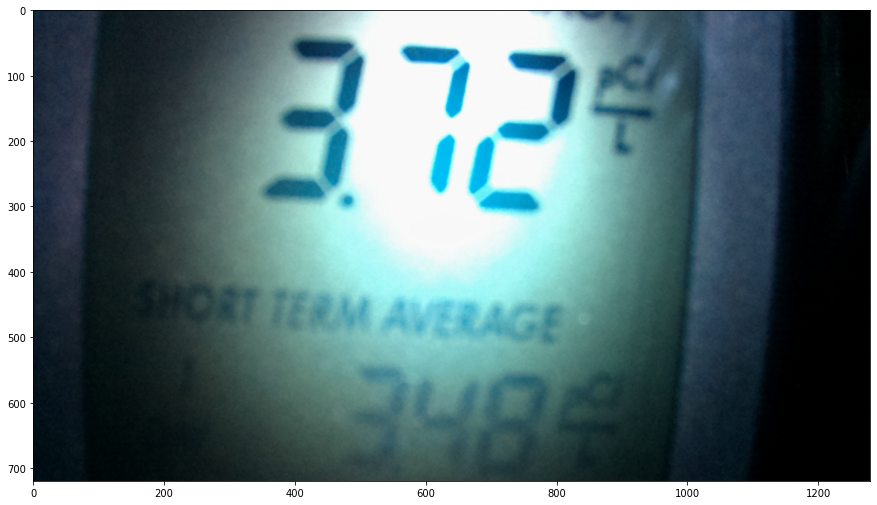

In [9]:
%%time
i = random.randint(0,len(new_img))
fp = new_img.loc[0,'img_path']
nn_values = read_image(fp,nn_model,display_img = False,normalize = True)
values = read_image(fp,clf,returns_array = False,display_img = True)
print('log_reg values = {}'.format(values))
print('Sequential NN values = {}'.format(nn_values))
print('Photo taken: ',dt.datetime.strptime(fp[-19:-4],"%m-%d-%Y_%H%M"))

## Reading the Images

In [10]:
from joblib import dump, load
clf = load('logistic_regression.joblib') 
nn_model = load('nn_model.joblib')

In [210]:
%%time
def read_files(df,fname = None,samples = None):
    '''reades files from dataframe.  Dataframe must have a img_path column'''
    
    print('0 out of {} complete'.format(len(df)))
    i_time = time.time()
    for i, fp in enumerate(df['img_path']):
        
        try:
            log_results = read_image(fp,clf,returns_array = False)
            nn_results = read_image(fp,nn_model,normalize = True)
        except:pass
        df.loc[i,'short_term_span'] = log_results['days']
        df.loc[i,'short_term'] = log_results['short_term']
        df.loc[i,'long_term'] = log_results['long_term']
        df.loc[i,'nn_short_term_span'] = nn_results['days']
        df.loc[i,'nn_short_term'] = nn_results['short_term']
        df.loc[i,'nn_long_term'] = nn_results['long_term']
        if (df.loc[i,'short_term_span'] != df.loc[i,'nn_short_term_span']) or (df.loc[i,'short_term'] != df.loc[i,'nn_short_term'])or(df.loc[i,'long_term'] != df.loc[i,'nn_long_term']):
            df.loc[i,'models agree'] = False
        else: df.loc[i,'models agree'] = True
        if (i>0) & (i%50==0):
            f_time = time.time()
            print('{} out of {} complete in {} seconds'.format(i,len(df),round(f_time-i_time,1)))
            i_time = time.time()
            try:df.to_csv(fname)
            except:_ = input('Try closing results.csv')
        if not samples == None:
            if i>samples: break
    df['hour'] = df.img_date.dt.hour
    df['month'] = df.img_date.dt.month
    if not fname == None:
        try:df.to_csv(fname)
        except:_ = input('Try closing results.csv')

    return df
new_img = read_files(new_img)
print('Model agreement = {}%'.format(100*round(sum(new_img['models agree'])/len(new_img['models agree']),2)))
new_img.head()  

0 out of 35 complete
Model agreement = 69.0%
CPU times: user 47 s, sys: 3.2 s, total: 50.2 s
Wall time: 1min 5s


,img_date,img_path,img_name,short_term_span,short_term,long_term,nn_short_term_span,nn_short_term,nn_long_term,models agree,hour,month
0,2022-02-20 09:25:00,/Volumes/sambashare/projects/radon_monitor/dat...,tests_02-20-2022_0925.png,1.0,1.44,3.75,1.0,1.44,3.75,True,9,2
1,2022-02-20 08:24:00,/Volumes/sambashare/projects/radon_monitor/dat...,tests_02-20-2022_0824.png,1.0,2.17,3.75,1.0,2.13,3.75,False,8,2
2,2022-02-20 07:23:00,/Volumes/sambashare/projects/radon_monitor/dat...,tests_02-20-2022_0723.png,7.0,3.18,3.75,7.0,3.18,3.75,True,7,2
3,2022-02-20 06:22:00,/Volumes/sambashare/projects/radon_monitor/dat...,tests_02-20-2022_0622.png,1.0,3.18,3.75,1.0,3.16,3.75,False,6,2
4,2022-02-20 05:21:00,/Volumes/sambashare/projects/radon_monitor/dat...,tests_02-20-2022_0521.png,1.0,2.08,3.75,1.0,2.08,3.75,True,5,2


In [211]:
df = pd.concat([img_df,new_img])

## Reading a specific day


        --------------------------------------------
        Logistic Regression      | NN
        ---------------------------------------------
        short_term_span = 1.0    |short_term_span = 1.0
        long_term = 3.75         |long_term = 3.75
        short_term = 2.44        |short_term = 2.44

        


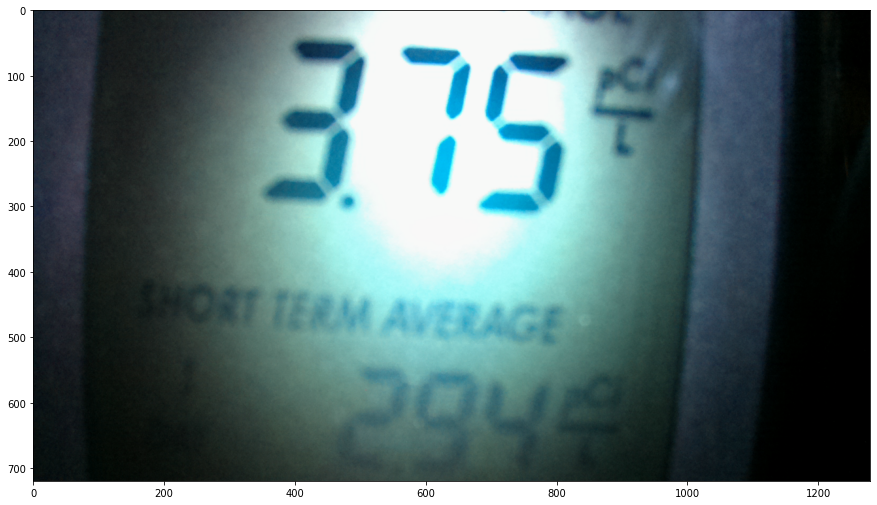

In [56]:
def read_specific_day(df,year = 2021,day = 22, month = 11,hour = 6):
    '''reads from data (i.e. does not use any modeling)'''
    date = dt.date(year = year,day=day,month = month)
    hour_mask = df['hour'] == hour
    date_mask = df['img_date'].dt.date == date
    row = df[date_mask]
    if len(row) != 0:
        row = df[date_mask&hour_mask]
        if len(row) != 0:
            print('''
        --------------------------------------------
        Logistic Regression      | NN
        ---------------------------------------------
        short_term_span = {}    |short_term_span = {}
        long_term = {}         |long_term = {}
        short_term = {}        |short_term = {}

        '''.format(
            row.short_term_span.values[0], row.nn_short_term_span.values[0],
            row.long_term.values[0],row.nn_long_term.values[0],
            row.short_term.values[0],row.nn_short_term.values[0]))
            
            rm.browse_photos(row.img_path.values[0])
        else:
            print('Hour not found')
    else:
        print('Date not found')
    
    
read_specific_day(df,year = 2022,day = 23, month = 1,hour = 19)

log_reg values = {'days': 1, 'short_term': 3.35, 'long_term': 3.72}
Sequential NN values = {'days': 1, 'short_term': 3.35, 'long_term': 3.72}
Photo taken:  2021-11-20 15:45:00
/Volumes/sambashare/projects/radon_monitor/data/hourly_tests/tests_11-20-2021_1545.png


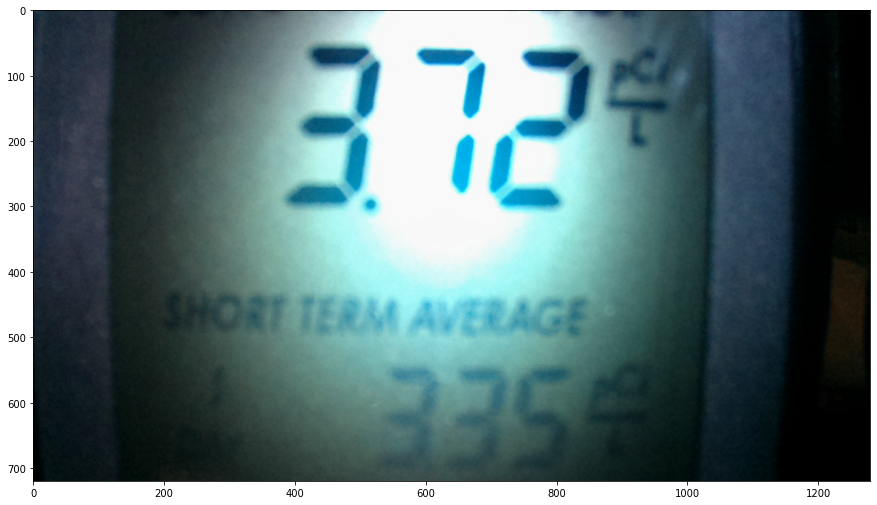

In [13]:
def model_read_day(df,year = 2021,day = 22, month = 11,hour = 6):
    '''reads data using the models'''
    date = dt.date(year = year,day=day,month = month)
    date_mask = df['img_date'].dt.date == date
    hour_mask = df['hour'] == hour
    row = df[date_mask]
    if len(row) != 0:
        row = df[date_mask&hour_mask]
        if len(row)!=0:
            fp = df[date_mask&hour_mask].img_path.values[0]
            nn_values = read_image(fp,nn_model,display_img = False,normalize = True)
            values = read_image(fp,clf,returns_array = False,display_img = True)
            print('log_reg values = {}'.format(values))
            print('Sequential NN values = {}'.format(nn_values))
            print('Photo taken: ',dt.datetime.strptime(fp[-19:-4],"%m-%d-%Y_%H%M"))
            print(fp)
        else: print('Hour not found')
    else:print('Date not found')
inaccurate_day = 'year = 2021,day = 20, month = 11,hour = 15' # copy in for case of inaccurate reading due to calibration

model_read_day(df,year = 2021,day = 20, month = 11,hour = 15)

## Assessing where the models disagree

Note: The Neural Net appears to struggle with the short_term_span reading while it appears to out compete the logistic regression model everywhere else

Total model disagreements = 11 out of 35
        Example = 0 Date = 20-Feb-2022
        --------------------------------------------
        Logistic Regression      | NN
        ---------------------------------------------
        short_term_span = 1.0    |short_term_span = 1.0
        long_term = 3.75         |long_term = 3.75
        short_term = 2.17        |short_term = 2.13

        


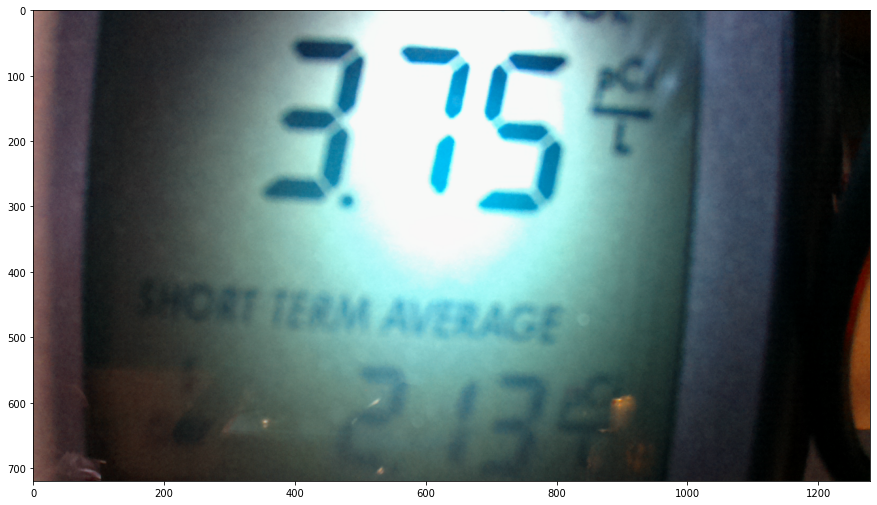

Continue to next example? y/n y


Total model disagreements = 11 out of 35
        Example = 1 Date = 20-Feb-2022
        --------------------------------------------
        Logistic Regression      | NN
        ---------------------------------------------
        short_term_span = 1.0    |short_term_span = 1.0
        long_term = 3.75         |long_term = 3.75
        short_term = 3.18        |short_term = 3.16

        


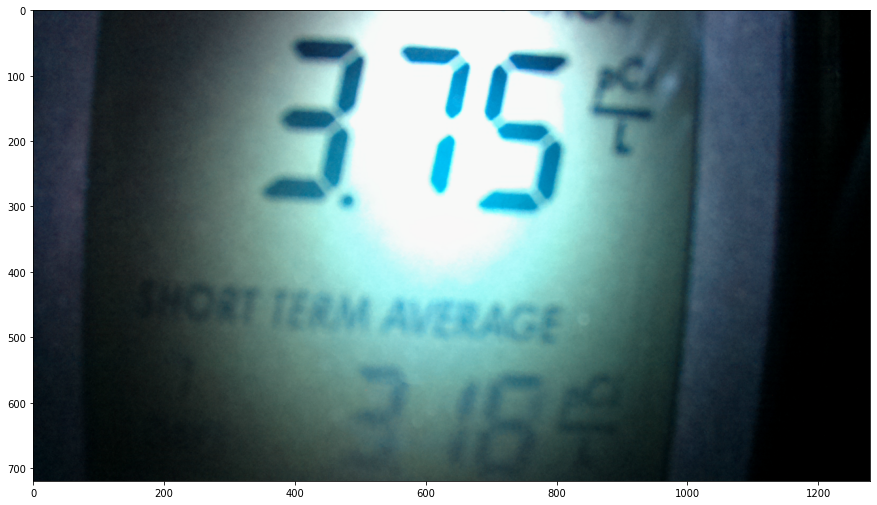

Continue to next example? y/n n


In [212]:
def assess_model_disagreements(df):
    disagree_df = df[df['models agree']==False].reset_index(drop = True)
    i = 0
    while True:
        row = disagree_df.loc[i]
        print('''Total model disagreements = {} out of {}
        Example = {} Date = {}
        --------------------------------------------
        Logistic Regression      | NN
        ---------------------------------------------
        short_term_span = {}    |short_term_span = {}
        long_term = {}         |long_term = {}
        short_term = {}        |short_term = {}

        '''.format(len(disagree_df),sum(~df['short_term_span'].isna()),i,row.img_date.strftime('%d-%b-%Y'),
            row.short_term_span, row.nn_short_term_span,
            row.long_term,row.nn_long_term,
            row.short_term,row.nn_short_term))
        fp = disagree_df.loc[i,'img_path']
        rm.browse_photos(fp)
        ans = input("Continue to next example? y/n")
        if ans == 'y':
            i+=1
            if i == len(disagree_df ):
                print("End of disagreements")
                break
            continue
        else: break
    
assess_model_disagreements(new_img)


## Visualizations

In [213]:
df = df.sort_values(by = 'img_date')

In [214]:
pd.to_datetime(rm.calibrated_dates)

DatetimeIndex(['2021-11-01', '2021-11-20', '2021-11-21', '2021-11-23',
               '2021-12-11', '2021-12-18', '2021-12-31'],
              dtype='datetime64[ns]', freq=None)

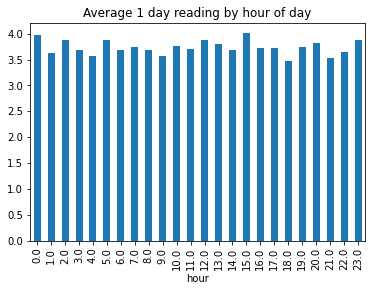

In [215]:
df[df['short_term_span']==1].groupby('hour')['nn_short_term'].mean().plot(kind = 'bar')
plt.title('Average 1 day reading by hour of day')
plt.show()


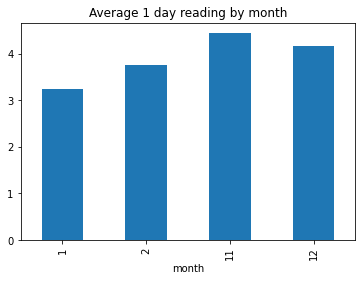

In [216]:
df[df['nn_short_term_span']==1].groupby('month')['nn_short_term'].mean().plot(kind = 'bar')
plt.title('Average 1 day reading by month')
plt.show()

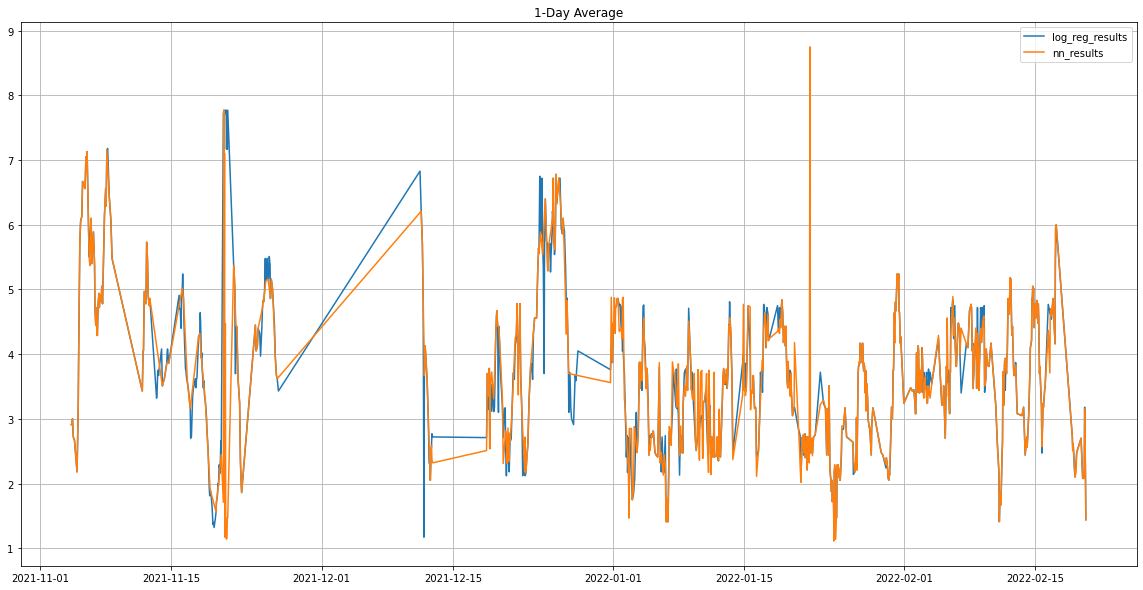

In [217]:
st_time_span = 1
x = df.img_date[df['short_term_span'] == st_time_span]
x2 = df.img_date[df['nn_short_term_span'] == st_time_span]
y = df.short_term[df['short_term_span']==st_time_span]
y2 = df.nn_short_term[df['nn_short_term_span']==st_time_span]
plt.figure(figsize = (20,10))
plt.title('1-Day Average')
plt.plot(x,y,label = 'log_reg_results')
plt.plot(x2,y2,label='nn_results')
plt.grid(True)
plt.legend()
plt.show()

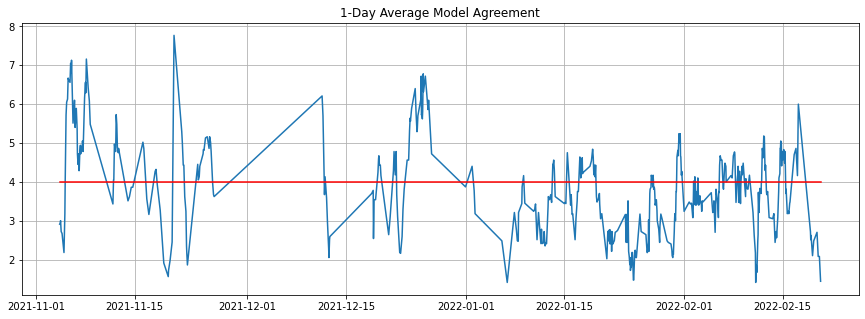

In [218]:
# removing disagreeing data
st_time_span = 1
models_agree_df = df[df['models agree']==True].reset_index(drop = True)
models_agree_df=models_agree_df.sort_values(by='img_date')
x = models_agree_df.img_date[models_agree_df['short_term_span'] == st_time_span]
x2 = models_agree_df.img_date[models_agree_df['nn_short_term_span'] == st_time_span]
y = models_agree_df.short_term[models_agree_df['short_term_span']==st_time_span]
y2 = models_agree_df.nn_short_term[models_agree_df['short_term_span']==st_time_span]
plt.figure(figsize = (15,5))
plt.title('1-Day Average Model Agreement')
plt.plot(x,y)
#plt.plot(x2,y2)
plt.plot(x,len(x)*[4],color = 'r')

plt.grid(True)
#plt.legend()
plt.show()


In [219]:
import sqlite3
conn = sqlite3.connect('/Volumes/sambashare/projects/radon_monitor/data/environmental_data.sqlite')
cursor = conn.cursor()
q = '''
SELECT date, temp,pressure,humidity
FROM daily_weather'''
cursor.execute(q)
rows= cursor.fetchall()
daily_weather_df = pd.DataFrame.from_records(rows,columns = ['DATE','hourly_temp','pressure','humidity'])
daily_weather_df['DATE'] = pd.to_datetime(daily_weather_df['DATE'])
daily_weather_df.tail()

,DATE,hourly_temp,pressure,humidity
577,2022-02-20 05:06:00,24.1,1013.0,67.0
578,2022-02-20 06:06:00,25.5,1012.0,68.0
579,2022-02-20 07:06:00,27.2,1008.0,69.0
580,2022-02-20 08:06:00,30.0,1008.0,67.0
581,2022-02-20 09:06:00,34.4,1007.0,62.0


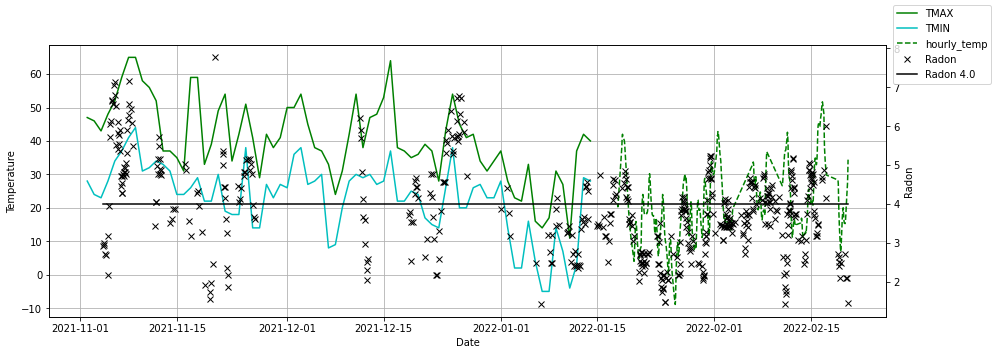

In [220]:
fig, ax1 = plt.subplots(figsize = (15,5))

weather_data = pd.read_csv('./reference_data/clean_weather_data.csv')
weather_data["DATE"] = pd.to_datetime(weather_data["DATE"])
weather_data = weather_data[['DATE','TMAX','TMIN']][weather_data["DATE"]>pd.to_datetime('11/01/2021')]

weather_data = pd.concat([weather_data,daily_weather_df])

x2 = models_agree_df.img_date[models_agree_df['nn_short_term_span'] == st_time_span]
y2 = models_agree_df.nn_short_term[models_agree_df['short_term_span']==st_time_span]

ax2 = ax1.twinx()
ax1.plot(weather_data['DATE'], weather_data['TMAX'], 'g-',label = 'TMAX')
ax1.plot(weather_data['DATE'], weather_data['TMIN'], 'c-',label = 'TMIN')
ax1.plot(weather_data['DATE'], weather_data['hourly_temp'], 'g--',label = 'hourly_temp')
ax2.plot(x2, y2, 'kx',label='Radon')
ax2.plot(x,len(x)*[4],color = 'k',label='Radon 4.0')
ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature')
ax2.set_ylabel('Radon')
ax1.grid()
fig.legend(loc = 'upper right')
plt.show()

In [221]:
fig.savefig('./figures/radon_temp_ts.jpg')

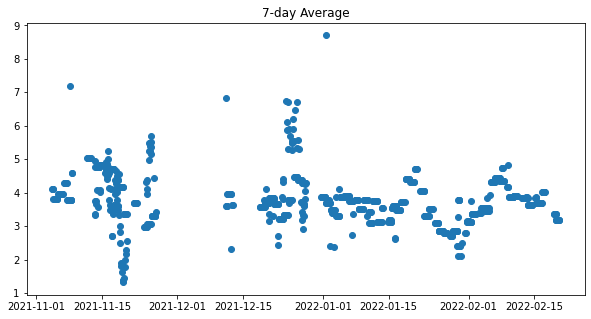

In [222]:
st_time_span = 7
x = df.img_date[df['nn_short_term_span'] == st_time_span]
y = df.nn_short_term[df['nn_short_term_span']==st_time_span]
plt.figure(figsize = (10,5))
plt.title('7-day Average')
plt.scatter(x,y)
plt.show()

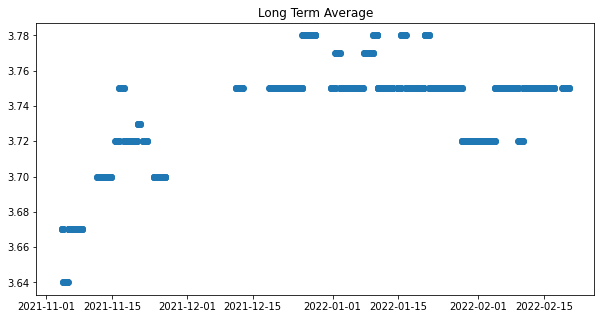

In [223]:

x = df.img_date
y = df.nn_long_term
plt.figure(figsize = (10,5))
plt.title('Long Term Average')
plt.scatter(x,y)
plt.show()

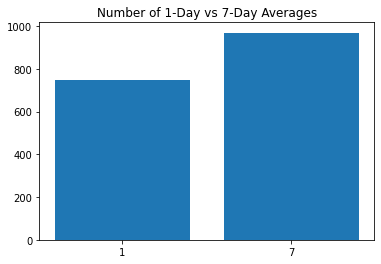

In [224]:
plt.title('Number of 1-Day vs 7-Day Averages')
plt.bar(x= ["1","7"],height = [(df['nn_short_term_span'] == 1).sum(),(df['nn_short_term_span'] == 7).sum()])
plt.show()

## Save

In [225]:
df.to_csv('./results.csv',index = False)